# Classifying Population Dynamics

In [1]:
%run ../src/dataset.py
%run ../src/augmentation.py
%run ../src/simulation.py
%run ../src/nets.py
%run ../src/trainer.py
%run ../src/utils.py

Train a model based on Wright-Fisher simulations (without age structure).

In [2]:
classifier = TimeseriesClassifier(
    classifier=MultiLayerPerceptron(128, layers=(64, 64, 64)),
    embedder=ResNet(1)
)

In [3]:
tranformer = Compose(Normalizer(), Standardizer())
data = PresimulatedDataset.load("../data/20210405204149.npz")#, transform=Normalizer())

In [4]:
len(set(data.ids))

50000

In [5]:
data[8000]

(tensor([0.1102, 0.0481, 0.3748]),
 tensor([638.0000,  61.7408,   2.1469,   1.2696,   1.1740,   1.1431,   1.1279]))

Train the actual model. In each epoch, we simulate 50k samples with different parameters, $\theta$. The training procedure can probably be improved, but it already produces reasonable results.

In [6]:
classifier, train_loader, val_loader = train(
    data=data,
    classifier=classifier, 
    n_epochs=40, 
    batch_size=500, 
    device="cuda", 
    learning_rate=0.001,
    num_workers=40
)

Epoch  1: train loss = 0.26, val loss = 0.20, AUC = 0.97 ++
Epoch  2: train loss = 0.18, val loss = 0.19, AUC = 0.97 ++
Epoch  3: train loss = 0.16, val loss = 0.18, AUC = 0.97 ++
Epoch  4: train loss = 0.16, val loss = 0.18, AUC = 0.97 --
Epoch  5: train loss = 0.15, val loss = 0.18, AUC = 0.97 ++
Epoch  6: train loss = 0.15, val loss = 0.15, AUC = 0.97 ++
Epoch  7: train loss = 0.15, val loss = 0.15, AUC = 0.97 ++
Epoch  8: train loss = 0.15, val loss = 0.15, AUC = 0.98 ++
Epoch  9: train loss = 0.15, val loss = 0.15, AUC = 0.98 --
Epoch 10: train loss = 0.14, val loss = 0.14, AUC = 0.98 ++
Epoch 11: train loss = 0.14, val loss = 0.14, AUC = 0.98 --
Epoch 12: train loss = 0.14, val loss = 0.14, AUC = 0.98 --
Epoch 13: train loss = 0.14, val loss = 0.15, AUC = 0.98 --
Epoch 14: train loss = 0.14, val loss = 0.14, AUC = 0.98 --
Epoch 15: train loss = 0.14, val loss = 0.16, AUC = 0.97 --
Epoch 16: train loss = 0.14, val loss = 0.14, AUC = 0.98 ++
Epoch 17: train loss = 0.14, val loss = 

In [14]:
import multiprocessing as mp

classifier.eval()

def classify(theta, simulator, num_experiments=100, n_jobs=1):
    with mp.Pool(n_jobs) as pool:
        x = np.vstack(
            pool.starmap(simulator, [(theta, np.random.RandomState(i)) for i in range(num_experiments)])
        )
    with torch.no_grad():
        output = classifier(torch.FloatTensor(x).unsqueeze(1).to("cuda"))
    return output

In [10]:
import json

with open("../data/20210405204149.params.json") as f:
    params = json.load(f)
params

{'agents': 10000,
 'timesteps': 1000,
 'simulations': 50000,
 'workers': 40,
 'burn_in': 1000,
 'top_n': 0,
 'summarize': True}

In [11]:
neutral_simulator = Simulator(
    n_agents=params["agents"], 
    timesteps=params["timesteps"],
    age_window=None,
    disable_pbar=True,
    summarize=True
)

Test the performance of the model by classifying some generated samples. Given some $\theta_i$, we simulate 100 samples, and use the trained classifier to 'predict' whether they are examples of neutral evolution or not. The function returns the fraction of biased samples. 

First, let's test whether the model accurately classifies neutral samples to be neutral:

In [18]:
theta = torch.tensor([0., 0.01, 0.5])
output = classify(theta, neutral_simulator, n_jobs=25)
pred = (output < 0.5).float().mean().item()

print(f"p(theta=0|x) = {pred:.3f}")

p(theta=0|x) = 0.990


That seems to be working. And what about non-neutral, biased samples?

In [16]:
theta = torch.tensor([0.1, 0.01, 0.5])
output = classify(theta, neutral_simulator, n_jobs=25)
pred = (output > 0.5).float().mean().item()

print(f"p(theta=1|x) = {pred:.3f}")

p(theta=1|x) = 1.000


Also not bad. 

Next, we generate samples with the age-structured model and see whether the model (which was only trained on samples _without_ age structure) can still accurately discriminate between neutral an non-neutral samples:

In [19]:
age_structured_simulator = Simulator(
    n_agents=params["agents"], 
    timesteps=params["timesteps"],
    age_window=(0, 2),
    disable_pbar=True,
    summarize=True
)

In [20]:
theta = torch.tensor([0., 0.01, 0.5])
output = classify(theta, age_structured_simulator, n_jobs=25)
pred = (output < 0.5).float().mean().item()

print(f"p(theta=0|x) = {pred:.3f}")

p(theta=0|x) = 1.000


In [21]:
theta = torch.tensor([0.1, 0.01, 0.5])
output = classify(theta, age_structured_simulator, n_jobs=25)
pred = (output > 0.5).float().mean().item()

print(f"p(theta=1|x) = {pred:.3f}")

p(theta=1|x) = 1.000


The first preliminary results suggest that the performance of the classifier is not too strongly affected by age structure. But Let's look at that in some more detail. In the following code blocks, we simulate and classify samples with $\beta$ from [-0.1, 0.1] in 100 equally spaced subintervals. For each value $\beta_i$, we sample 100 examples with the standard Wright-Fisher model and 100 with the age-structured model. We store the resulting probabilities of each sample being non-neutral.

In [23]:
import tqdm

betas = np.linspace(-0.1, 0.1, num=101)

neutral_scores, age_scores = [], []
for beta in tqdm.tqdm(betas):
    theta = torch.tensor([beta, 0.01, 0.5])
    neutral_scores.append(classify(theta, neutral_simulator, n_jobs=25).cpu().numpy())
    age_scores.append(classify(theta, age_structured_simulator, n_jobs=25).cpu().numpy())

100%|██████████| 101/101 [43:32<00:00, 25.87s/it]


In [24]:
neutral_results = np.array(neutral_scores)
age_results = np.array(age_scores)

The plot below visualizes the results:

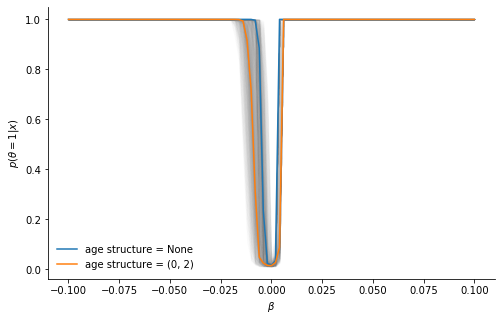

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))

tsplot(neutral_results.T, betas, color="grey", line_color="C0", ax=ax, percentile_min=5.5, 
       percentile_max=94.5, label="age structure = None")
tsplot(age_results.T, betas, color="grey", line_color="C1", ax=ax, percentile_min=5.5, 
       percentile_max=94.5, label="age structure = (0, 2)")

ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set(xlabel=r"$\beta$", ylabel=r"$p(\theta=1|x)$");

plt.savefig("plotje.png", dpi=300)

With $\beta$ closer to zero (i.e. when the selection strength is smaller), the average probability of samples being non-neutral goes down. Note however, that the probability decline happens sooner for the age structured model than for the regular wright fisher model. Whether this is a robust result, remains to be seen.